# Testing notebook for nifty fit on atmosphere TODs directly (no image)

# Try to add a nifty model for sampling the input map

numpy version: 2.1.1


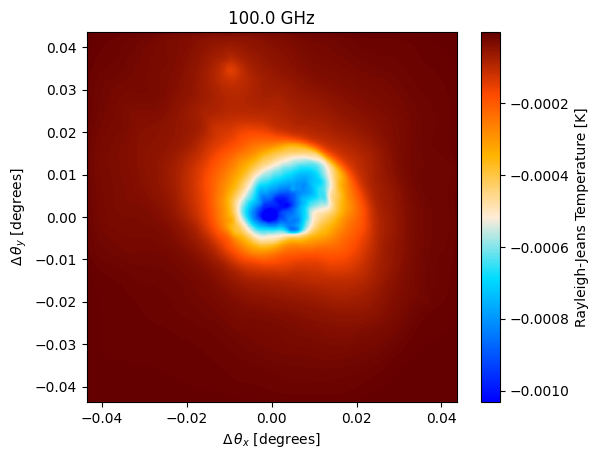

In [1]:
import numpy as np
print(f"numpy version: {np.__version__}")
import matplotlib.pyplot as plt
import maria
import sys
import os

# Relative import of sample_maps for now
sys.path.append(os.path.abspath('../python'))
import mapsampling_jax
from mapsampling_jax import sample_maps

map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()

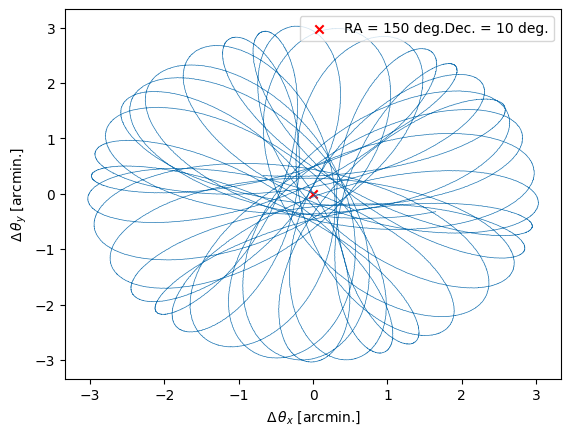

In [ ]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                    # duration=60,
                    #   duration=300, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

2024-10-16 15:12:57.615 INFO: Initialized base in 1708 ms.
Building atmosphere: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]
2024-10-16 15:13:03.549 INFO: Initialized atmosphere in 5919 ms.
Generating noise: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


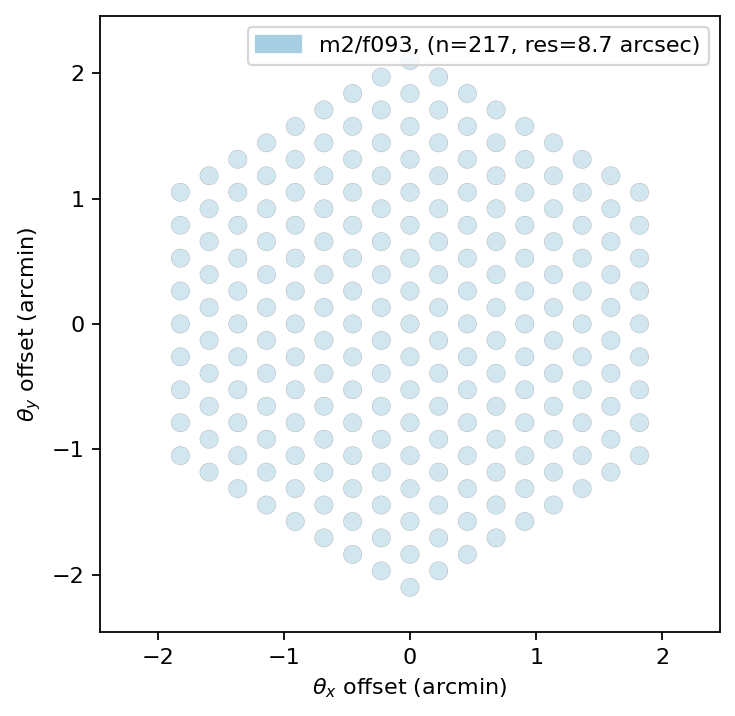

In [3]:
# instrument = maria.get_instrument('MUSTANG-2')
instrument = mapsampling_jax.instrument
instrument.plot()

sim_truthmap = maria.Simulation(instrument, 
                                plan=plan,
                                site="llano_de_chajnantor", 
                                map=input_map,
                                # noise=False,
                                atmosphere="2d",
                                # cmb="generate",
                                )

tod_truthmap = sim_truthmap.run()

In [4]:
dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)
dx = dx.compute()
dy = dy.compute()

dx

array([[-1.95327390e-04, -1.93257687e-04, -1.90472134e-04, ...,
         4.73198113e-04,  4.76341959e-04,  4.79461714e-04],
       [-2.44446609e-04, -2.42376886e-04, -2.39591440e-04, ...,
         4.27851524e-04,  4.30995217e-04,  4.34114827e-04],
       [-1.20137229e-04, -1.18067521e-04, -1.15281993e-04, ...,
         5.49076116e-04,  5.52219941e-04,  5.55339676e-04],
       ...,
       [ 1.22436221e-04,  1.24505762e-04,  1.27292193e-04, ...,
         7.60092770e-04,  7.63237857e-04,  7.66358791e-04],
       [-4.03894910e-04, -4.01825401e-04, -3.99038799e-04, ...,
         2.28946740e-04,  2.32091976e-04,  2.35213051e-04],
       [-7.44706806e-04, -7.42637090e-04, -7.39851605e-04, ...,
        -7.27630995e-05, -6.96194307e-05, -6.64998446e-05]])

Running mapper (m2/f093): 100%|██████████| 1/1 [00:17<00:00, 17.87s/it]


mapdata_truth shape: (1, 1000, 1000)
mapdata_truth mean: -8.726028151723567e-05


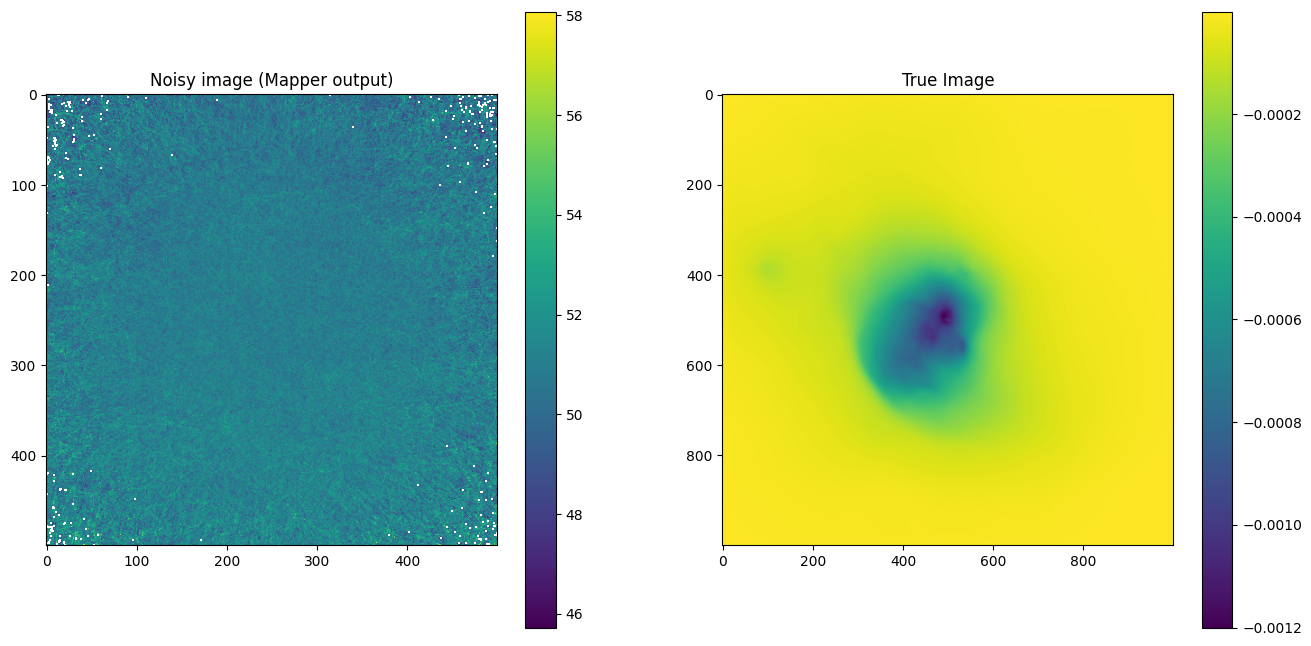

In [5]:
from maria.map.mappers import BinMapper

# Run mapper without any filtering to get noisy mimge
mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

mapdata_truth = np.float64(sim_truthmap.map.data)
mapdata_truth = np.nan_to_num(mapdata_truth, nan=np.nanmean(mapdata_truth)) # replace nan value by img mean

print("mapdata_truth shape:", mapdata_truth.shape)
print("mapdata_truth mean:", mapdata_truth.mean())

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(output_truthmap.data[0].T)
fig.colorbar(im0)
axes[0].title.set_text("Noisy image (Mapper output)")

im1 = axes[1].imshow(mapdata_truth[0])
fig.colorbar(im1)
axes[1].title.set_text("True Image")

plt.show()

# Re-implement map sampling in JAX for nifty response function:

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import jax
from jax import random
import jax.numpy as jnp

import nifty8.re as jft
import matplotlib.pyplot as plt

import numpy as np

from functools import reduce
from operator import or_

seed = 42
key = random.PRNGKey(seed)

2024-10-16 15:13:45.793 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-10-16 15:13:45.795 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


# Test TOD agreement:

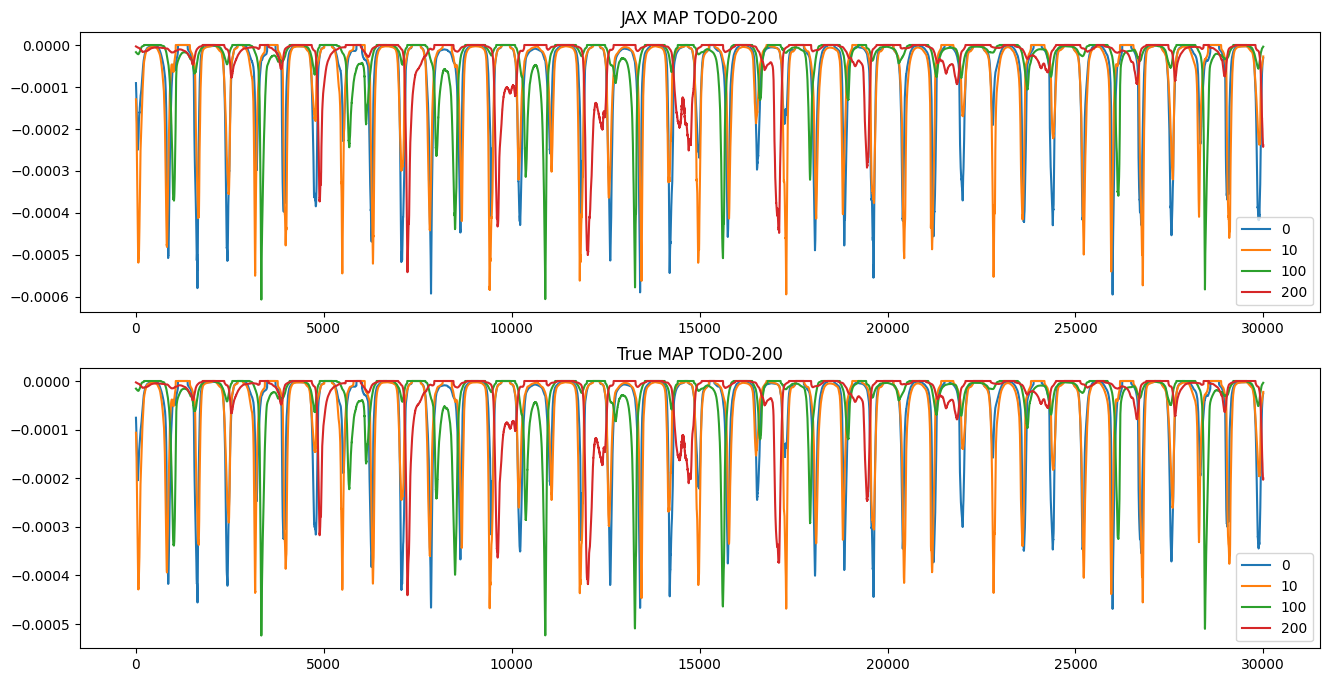

In [7]:
jax_tods_map = sample_maps(mapdata_truth, dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods_map[i], label=i)

    tods_map = np.float64(tod_truthmap.get_field('map').compute())
    im1 = axes[1].plot(tods_map[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True MAP TOD0-{i}')
axes[1].legend()

plt.show()

/scratch/users/jwuerzin/miniconda3/envs/maria/lib/python3.11/site-packages/dask/array/core.py:1705: FutureWarning: The `numpy.interp` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


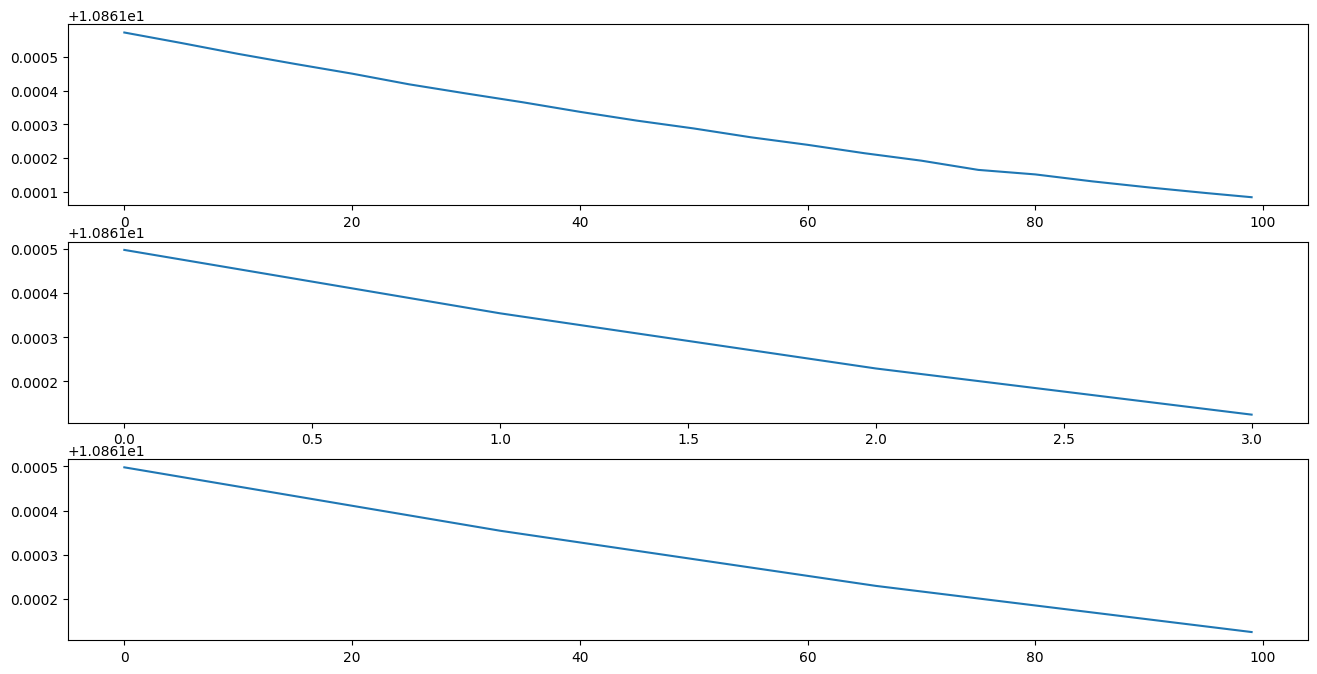

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(16, 8))
downsampling_factor = 25

test_atmos = tod_truthmap.get_field('atmosphere')[0, :100]
downsampled_arr = test_atmos.reshape(-1, downsampling_factor).mean(axis=1)

original_size = test_atmos.size
downsampled_size = downsampled_arr.size

x_original = np.linspace(0, original_size - 1, original_size)
x_downsampled = np.linspace(0, original_size - 1, downsampled_size)

stretched_arr = np.interp(x_original, x_downsampled, downsampled_arr)
stretched_arr2 = np.repeat(downsampled_arr, downsampling_factor)

im0 = axes[0].plot(test_atmos, label='full')
im1 = axes[1].plot(downsampled_arr, label='downsampled')
im2 = axes[2].plot(stretched_arr)

# Prepare noised input TODs:

Noise stddev: 0.00025158314671818485


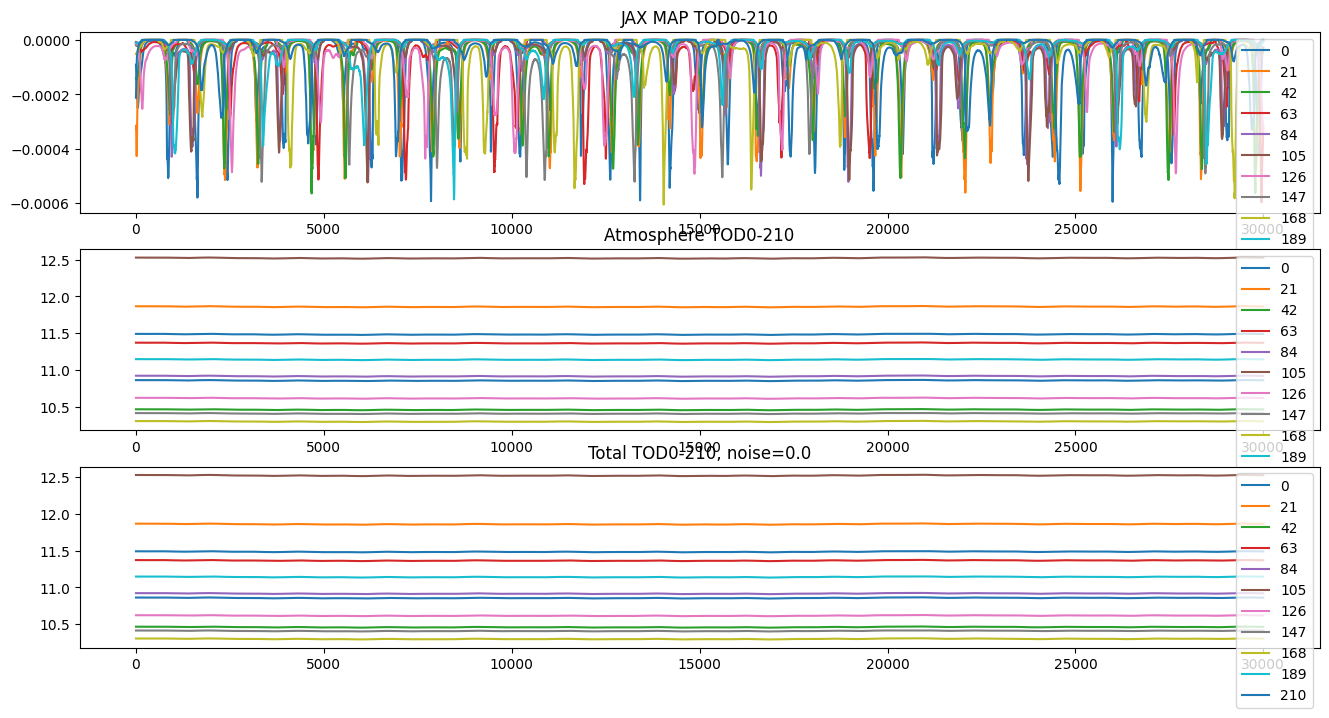

In [9]:
# Pick noise level for rest of run:
noiselevel = 0.0
# noiselevel = 0.1
# noiselevel = 0.5
# noiselevel = 1.0

# Add n TODs for atmos:
# n = 1
# n = 10
# n = 100
n = jax_tods_map.shape[0]

jax_tods_atmos = tod_truthmap.get_field('atmosphere')
# noised_jax_tod = np.float64(jax_tods_map) + np.float64(jax_tods_atmos) + np.float64(tod_truthmap.components['noise']*noiselevel)

noised_jax_tod = np.float64(jax_tods_map) + np.float64(tod_truthmap.get_field('noise')*noiselevel)
# noised_jax_tod[:n] += np.float64(jax_tods_atmos[:n]) 
noised_jax_tod[:n] = np.float64(jax_tods_atmos[:n])

denoised_jax_tod = noised_jax_tod - np.float64(tod_truthmap.get_field('noise')*noiselevel)

print("Noise stddev:", np.std(tod_truthmap.get_field('noise').compute()))

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

for i in range(0, n, n//10):
    im0 = axes[0].plot(jax_tods_map[i], label=i)
    im1 = axes[1].plot(jax_tods_atmos[i], label=i)
    im2 = axes[2].plot(noised_jax_tod[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'Atmosphere TOD0-{i}')
axes[1].legend()
axes[2].title.set_text(f'Total TOD0-{i}, noise={noiselevel}')
axes[2].legend()

plt.show()

# Next, initialise nifty prior model

Start with the atmosphere TOD model. For this, we need to re-write the CorrelatedFieldMaker:

In [10]:
import jax

import jax.numpy as jnp
import numpy as np
import nifty8.re as jft
import matplotlib.pyplot as plt

from functools import partial
from nifty8.re.correlated_field import Model, RegularCartesianGrid, hartley, HEALPixGrid, get_sht, ShapeWithDtype, random_like

key = jax.random.PRNGKey(42)

In [11]:
class CFM(jft.CorrelatedFieldMaker):
    def __init__(self, prefix):
        super().__init__(prefix)

    def finalize(self, n_fields: int = 0) -> Model:
        """Finishes off the model construction process and returns the
        constructed operator.
        """
        harmonic_transforms = []
        excitation_shape = ()
        for sgrid in self._target_grids:
            sub_shp = None
            sub_shp = sgrid.harmonic_grid.shape
            excitation_shape += sub_shp
            n = len(excitation_shape)
            harmonic_dvol = 1.0 / sgrid.total_volume
            if isinstance(sgrid, RegularCartesianGrid):
                axes = tuple(range(n - len(sub_shp), n))
                # TODO: Generalize to complex
                trafo = partial(hartley, axes=axes)
            elif isinstance(sgrid, HEALPixGrid):
                axis = len(excitation_shape) - 1
                trafo = get_sht(
                    nside=sgrid.nside,
                    axis=axis,
                    lmax=sgrid.harmonic_grid.lmax,
                    mmax=sgrid.harmonic_grid.mmax,
                    nthreads=1,
                )
            harmonic_transforms.append((harmonic_dvol, trafo))

        # Register the parameters for the excitations in harmonic space
        # TODO: actually account for the dtype here
        pfx = self._prefix + "xi"
        if n_fields > 0:
            xi_shape = (n_fields,) + excitation_shape
        else:
            xi_shape = excitation_shape
        self._parameter_tree[pfx] = ShapeWithDtype(xi_shape)

        def outer_harmonic_transform(p):
            harmonic_dvol, ht = harmonic_transforms[0]
            outer = harmonic_dvol * ht(p)
            for harmonic_dvol, ht in harmonic_transforms[1:]:
                outer = harmonic_dvol * ht(outer)
            return outer

        def _mk_expanded_amp(amp, sub_dom):  # Avoid late binding
            def expanded_amp(p):
                return amp(p)[sub_dom.harmonic_grid.power_distributor]

            return expanded_amp

        expanded_amplitudes = []
        namps = self.get_normalized_amplitudes()
        for amp, sgrid in zip(namps, self._target_grids):
            expanded_amplitudes.append(_mk_expanded_amp(amp, sgrid))

        def outer_amplitude(p):
            outer = expanded_amplitudes[0](p)
            for amp in expanded_amplitudes[1:]:
                # NOTE, the order is important here and must match with the
                # excitations
                # TODO, use functions instead and utilize numpy's casting
                outer = jnp.tensordot(outer, amp(p), axes=0)
            return outer

        def correlated_field(p):
            ea = outer_amplitude(p)
            cf_h = self.azm(p) * ea * p[self._prefix + "xi"]
            return self._offset_mean + outer_harmonic_transform(cf_h)
        
        p_dct = {k: 0 if 'xi' in k else None for k in self._parameter_tree}
        cfm_vmap = jax.vmap(correlated_field, in_axes=(p_dct,))

        init = {
            k: partial(random_like, primals=v) for k, v in self._parameter_tree.items()
        }
        cf = Model(cfm_vmap, domain=self._parameter_tree.copy(), init=init)
        cf.normalized_amplitudes = namps
        cf.target_grids = tuple(self._target_grids)
        return cf

In [12]:
# padding_atmos = 2000
padding_atmos = 5000
dims_atmos = ( (jax_tods_atmos.shape[1] + padding_atmos), )

# correlated field zero mode GP offset and stddev
cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.0005, 0.001))

# correlated field fluctuations (mostly don't need tuning)
# fluctuations: y-offset in power spectrum in fourier space (zero mode)
# loglogavgslope: power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
# flexibility=(1.5e0, 5e-1), # deviation from simple power-law
# asperity=(5e-1, 5e-2), # small scale features in power-law
cf_fl_tod = dict(
    # fluctuations=(0.005, 0.005), 
    fluctuations=(0.005, 0.003), 
    loglogavgslope=(-3, 0.5), 
    flexibility=None,
    asperity=None,
)

# put together in correlated field model
cfm_tod = CFM("combcf ")
cfm_tod.set_amplitude_total_offset(**cf_zm_tod)
cfm_tod.add_fluctuations(
    dims_atmos, distances=1.0 / dims_atmos[0], **cf_fl_tod, prefix="tod ", non_parametric_kind="power"
)
gp_tod = cfm_tod.finalize(n)

In [13]:
gp_tod

Model(
	<function CFM.finalize.<locals>.correlated_field at 0x151ceba33ce0>,
	domain={'combcf tod fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf tod loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf xi': ShapeWithDtype(shape=(217, 35000), dtype=<class 'jax.numpy.float64'>),
	 'combcf zeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)},
	init=Initializer(
		{'combcf tod fluctuations': functools.partial(<function random_like at 0x151ce0cbe3e0>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf tod loglogavgslope': functools.partial(<function random_like at 0x151ce0cbe3e0>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf xi': functools.partial(<function random_like at 0x151ce0cbe3e0>, primals=ShapeWithDtype(shape=(217, 35000), dtype=<class 'jax.numpy.float64'>)),
		 'combcf zeromode': functools.partial(<function random_like at 0x1

(217, 35000)


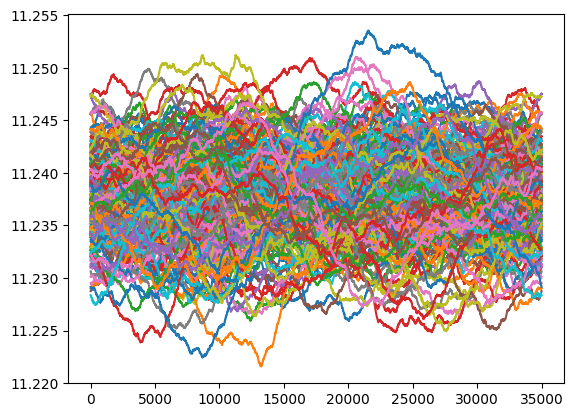

In [14]:
key, subkey = jax.random.split(key)
xi = jft.random_like(subkey, gp_tod.domain)
val = gp_tod(xi)
print(val.shape)
for i in range(n):
    plt.plot(np.arange(dims_atmos[0]), val[i])
plt.show()

In [15]:
# padding_atmos = 2000
# # padding_atmos = 200
# # dims_atmos = ( (jax_tods_atmos.shape[1] + padding_atmos)//downsampling_factor ,)
# dims_atmos = ( (jax_tods_atmos.shape[1] + padding_atmos), )

# # correlated field zero mode GP offset and stddev
# # cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.001, 0.1))
# cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.0005, 0.001))

# # correlated field fluctuations (mostly don't need tuning)
# # fluctuations: y-offset in power spectrum in fourier space (zero mode)
# # loglogavgslope: power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
# # flexibility=(1.5e0, 5e-1), # deviation from simple power-law
# # asperity=(5e-1, 5e-2), # small scale features in power-law
# cf_fl_tod = dict(
#     # fluctuations=(0.005, 0.005), 
#     fluctuations=(0.005, 0.003), 
#     loglogavgslope=(-3, 0.5), 
#     flexibility=None,
#     asperity=None,
# )

# # put together in correlated field model
# cfm_tod = jft.CorrelatedFieldMaker("")
# cfm_tod.set_amplitude_total_offset(**cf_zm_tod)
# cfm_tod.add_fluctuations(
#     dims_atmos, distances=1.0 / dims_atmos[0], **cf_fl_tod, prefix="tod ", non_parametric_kind="power"
# )
# # gp_tod = cfm_tod.finalize()

## Add one Correlated field per TOD with shared flucts and zero-mean

In [16]:
# # init params for each TOD:

# gps_tods = []
# for i in range(n):
#     cfmi = jft.CorrelatedFieldMaker(f'tod{i} ')
#     # cfmi.set_amplitude_total_offset(**cf_zm_tod)
#     cfmi._azm = cfm_tod._azm
#     cfmi._offset_mean = cfm_tod._offset_mean
#     cfmi._parameter_tree['zeromode'] = jft.ShapeWithDtype(())

#     cfmi._fluctuations.append(cfm_tod._fluctuations[0])
#     cfmi._target_grids.append(cfm_tod._target_grids[0])
#     cfmi._parameter_tree.update(cfm_tod._fluctuations[0].domain)
#     gps_tods.append(cfmi.finalize())

## Now for the map model:

In [17]:
dims_map = (1000, 1000)

# Map model

# correlated field zero mode GP offset and stddev
# cf_zm_map = dict(offset_mean=mapdata_truth.mean(), offset_std=(1e-7, 1e-6))
cf_zm_map = dict(offset_mean=mapdata_truth.mean(), offset_std=(1e-8, 1e-7))
# correlated field fluctuations (mostly don't need tuning)
cf_fl_map = dict(
    # fluctuations=(1e-6, 1e-6), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    fluctuations=(2e-6, 1e-6), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    loglogavgslope=(-2.5e0, 5e-1), # power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
    flexibility=None,
    asperity=None,
    # flexibility=(1.5e0, 5e-1), # deviation from simple power-law
    # asperity=(5e-1, 5e-2), # small scale features in power-law
)

# put together in correlated field model
cfm_map = jft.CorrelatedFieldMaker("cfmap")
cfm_map.set_amplitude_total_offset(**cf_zm_map)
cfm_map.add_fluctuations(
    dims_map, distances=1.0 / dims_map[0], **cf_fl_map, prefix="ax1", non_parametric_kind="power"
)
gp_map = cfm_map.finalize()

In [18]:
# only tod:
# class Signal_TOD(jft.Model):
#     def __init__(self, gps_tods):
#         # self.gp_tod = gp_tod
#         # super().__init__(init=self.gp_tod.init, domain=jft.Vector(gp_tod.domain))
#         self.gps_tods = gps_tods
#         self.tgt = (len(gps_tods), gps_tods[0].target.size)
#         # self.gp_map = gp_map
#         # super().__init__(init=reduce(or_, [gp.init for gp in gps_tods] + [gp_map.init]), domain=reduce(or_, [gp.domain for gp in gps_tods] + [gp_map.domain]))
#         super().__init__(init=reduce(or_, [gp.init for gp in gps_tods]), domain=reduce(or_, [gp.domain for gp in gps_tods]))
    
#     def __call__(self, x):
#         res_tods = jnp.zeros(self.tgt)
#         for i, gp in enumerate(self.gps_tods):
#             res_tods = res_tods.at[i].set(gp(x))
        
#         return res_tods[:, padding_atmos//2:-padding_atmos//2]

#         # res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

#         # # Only add first n atmosphere tods, otherwise use map
#         # modified_res_map = res_map.at[:n, :].add(res_tods[:, padding_atmos//2:-padding_atmos//2])

#         # return modified_res_map

# signal_response_tod = Signal_TOD(gps_tods)

# # map only:
# class Signal_TOD(jft.Model):
#     def __init__(self, gp_map):
#         # self.gp_tod = gp_tod
#         # super().__init__(init=self.gp_tod.init, domain=jft.Vector(gp_tod.domain))
#         # self.gps_tods = gps_tods
#         # self.tgt = (len(gps_tods), gps_tods[0].target.size)
#         self.gp_map = gp_map
#         # super().__init__(init=reduce(or_, [gp.init for gp in gps_tods] + [gp_map.init]), domain=reduce(or_, [gp.domain for gp in gps_tods] + [gp_map.domain]))
#         super().__init__(init=gp_map.init, domain=gp_map.domain)
    
#     def __call__(self, x):
#         # res_tods = jnp.zeros(self.tgt)
#         # for i, gp in enumerate(self.gps_tods):
#         #     res_tods = res_tods.at[i].set(gp(x))
        
#         res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
#         return res_map

#         # Only add first n atmosphere tods, otherwise use map
#         # modified_res_map = res_map.at[:n, :].add(res_tods[:, padding_atmos//2:-padding_atmos//2])

#         # return modified_res_map
#         # return res_tods[:, padding_atmos//2:-padding_atmos//2] + res_map
#         # return res_tods[:, padding_atmos//2:-padding_atmos//2] + res_map[:n]
  
# signal_response_tod = Signal_TOD(gp_map)

# Python for

In [19]:
# class Signal_TOD(jft.Model):
#     def __init__(self, gp_tod, gp_map):
#         self.gp_tod = gp_tod
#         # self.tgt = (len(gps_tods), gps_tods[0].target.size)
#         self.gp_map = gp_map
#         # super().__init__(init=reduce(or_, [gp.init for gp in self.gp_tod] + [self.gp_map.init]), domain=reduce(or_, [gp.domain for gp in self.gp_tod] + [self.gp_map.domain]))
#         super().__init__(init = self.gp_tod.init | self.gp_map.init, domain = self.gp_tod.domain | self.gp_map.domain)
    
#     def __call__(self, x):
#         print("HERE 1")
#         # ATTEMPT 1: FOR LOOP - slow
#         # res_tods = jnp.zeros(self.tgt)
#         # print("HERE 2")
#         # for i, gp in enumerate(self.gps_tods):
#         #     print("HERE 3", i)
#         #     res_tods = res_tods.at[i].set(gp(x))
#         res_tods = self.gp_tod(x)

#         print("HERE 4")
#         res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
#         print("HERE 5")
#         # Only add first n atmosphere tods, otherwise use map
#         modified_res_map = res_map.at[:n, :].add(res_tods[:, padding_atmos//2:-padding_atmos//2])
#         print("HERE 6")
#         return modified_res_map

# Using CFM - combined

In [20]:
# class Signal_TOD(jft.Model):
#     def __init__(self, gp_tod, gp_map):
#         self.gp_tod = gp_tod
#         self.gp_map = gp_map

#         super().__init__(init = self.gp_tod.init | self.gp_map.init, domain = self.gp_tod.domain | self.gp_map.domain)
    
#     def __call__(self, x):
#         x_tod = {k: x[k] for k in x if 'map' not in k}
#         res_tods = self.gp_tod(x_tod)

#         res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
#         # Only add first n atmosphere tods, otherwise use map
#         modified_res_map = res_map.at[:n, :].add(res_tods[:, padding_atmos//2:-padding_atmos//2])

#         return modified_res_map

# CFM - TOD

In [21]:
class Signal_TOD(jft.Model):
    def __init__(self, gp_tod):
        self.gp_tod = gp_tod
        super().__init__(init = self.gp_tod.init, domain = self.gp_tod.domain )
    
    def __call__(self, x):
        x_tod = {k: x[k] for k in x if 'map' not in k}
        res_tods = self.gp_tod(x_tod)
        # res_tods = self.gp_tod(x)

        return res_tods[:, padding_atmos//2:-padding_atmos//2]

In [22]:
signal_response_tod = Signal_TOD(gp_tod)
# signal_response_tod = Signal_TOD(gp_tod, gp_map)

# Define noise covariance
# if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x
if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 1e-8**-2 * x
elif noiselevel == 0.1: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 0.5: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 1.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x

# Combine in likelihood - only fit 0th TOD for now!
# truth = noised_jax_tod[:n]
truth = noised_jax_tod
lh_tod = jft.Gaussian( truth, noise_cov_inv_tod).amend(signal_response_tod)

# lh = lh_tod + lh_map
# lh = lh_map
lh = lh_tod

# lh_map_grad = jax.grad(lh_map)
lh_tod_grad = jax.grad(lh_tod)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


In [23]:
signal_response_tod

Signal_TOD(
	<bound method Signal_TOD.__call__>,
	domain={'combcf tod fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf tod loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf xi': ShapeWithDtype(shape=(217, 35000), dtype=<class 'jax.numpy.float64'>),
	 'combcf zeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)},
	init=Initializer(
		{'combcf tod fluctuations': functools.partial(<function random_like at 0x151ce0cbe3e0>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf tod loglogavgslope': functools.partial(<function random_like at 0x151ce0cbe3e0>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf xi': functools.partial(<function random_like at 0x151ce0cbe3e0>, primals=ShapeWithDtype(shape=(217, 35000), dtype=<class 'jax.numpy.float64'>)),
		 'combcf zeromode': functools.partial(<function random_like at 0x151ce0cbe3e0>, primals=ShapeW

# Draw Prior sample

(217, 30000)


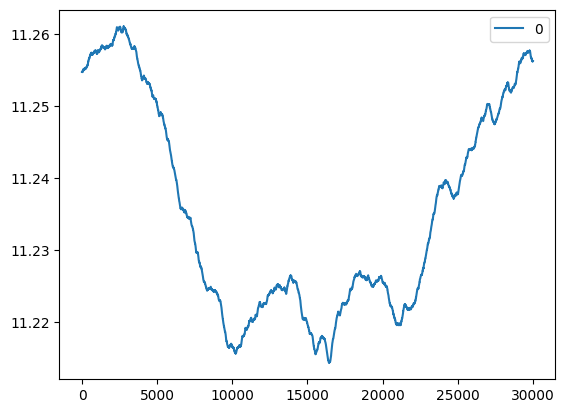

In [24]:
key, sub = jax.random.split(key)
xi = jft.random_like(sub, signal_response_tod.domain)
res = signal_response_tod(xi)
print(res.shape)

# for i in range(res.shape[0]):
# for i in range(0, n, n//10):
for i in [0]:
    plt.plot(np.arange(0, res.shape[1]), res[i], label=i)
plt.legend()
plt.show()

# MAP fit

In [25]:
n_it = 1
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4

n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60 # map
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=20 # map
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

OPTIMIZE_KL: Starting 0001
M: →:1.0 ↺:False #∇²:07 |↘|:3.460960e+05 ➽:7.595003e+02
M: Iteration 1 ⛰:+9.874064e+21 Δ⛰:7.137766e+18
M: →:1.0 ↺:False #∇²:13 |↘|:4.217776e+07 ➽:7.595003e+02
M: Iteration 2 ⛰:+9.873916e+21 Δ⛰:1.479462e+17
M: →:1.0 ↺:False #∇²:19 |↘|:4.465949e+07 ➽:7.595003e+02
M: Iteration 3 ⛰:+9.777615e+21 Δ⛰:9.630083e+19
M: →:0.25 ↺:True #∇²:26 |↘|:4.772884e+00 ➽:7.595003e+02
M: Iteration 4 ⛰:+9.323087e+21 Δ⛰:4.545282e+20
OPTIMIZE_KL: Iteration 0001 ⛰:+9.3231e+21
OPTIMIZE_KL: #(KL minimization steps) 4
OPTIMIZE_KL: Likelihood residual(s):
'reduced χ²: 2.9e+15±     0.0, avg:   +3e+04±     0.0, #dof:6510000'

OPTIMIZE_KL: Prior residual(s):
combcf tod fluctuations :: 'reduced χ²:    0.13±     0.0, avg:    +0.37±     0.0, #dof:      1'
combcf tod loglogavgslope:: 'reduced χ²: 1.4e+03±     0.0, avg: -3.7e+01±     0.0, #dof:      1'
combcf xi               :: 'reduced χ²: 2.5e+02±     0.0, avg:   +0.001±     0.0, #dof:7595000'
combcf zeromode         :: 'reduced χ²: 2.4e+04±   

In [26]:
samples.pos

Vector(
	{'combcf tod fluctuations': Array(0.36589781, dtype=float64),
	 'combcf tod loglogavgslope': Array(-37.32918331, dtype=float64),
	 'combcf xi': Array([[-360.31324991,   23.16267224,   39.92157208, ...,  100.94171876,
	          39.72795148,   13.06713259],
	       [1217.26331811,  -48.00794385, -134.97206396, ..., -325.51519891,
	        -134.58078652,  -45.27882919],
	       [-664.35825629,   18.49762147,   69.94412143, ...,  181.48522573,
	          68.85335185,   28.77643437],
	       ...,
	       [-168.11724415,    4.02652639,   20.28397422, ...,   47.50846202,
	          19.83528799,    9.22948959],
	       [-182.01321774,   -5.28787722,   20.78789481, ...,   49.7484891 ,
	          19.50344726,   14.75520898],
	       [ 462.36894261,  -20.33373464,  -46.8896612 , ..., -122.8831379 ,
	         -49.37154537,   -6.98353035]], dtype=float64),
	 'combcf zeromode': Array(-155.23473861, dtype=float64)}
)

In [27]:
def printfitresults():
    print("Fit Results (res, init, std)")

    print("\nTODs:")
    print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_tod['fluctuations'])(samples.pos['combcf tod fluctuations'])}, {cf_fl_tod['fluctuations'][0]}, {cf_fl_tod['fluctuations'][1]}")
    print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_tod['loglogavgslope'])(samples.pos['combcf tod loglogavgslope'])}, {cf_fl_tod['loglogavgslope'][0]}, {cf_fl_tod['loglogavgslope'][1]}")
    print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_tod['offset_std'])(samples.pos['combcf zeromode'])}, {cf_zm_tod['offset_std'][0]}, {cf_zm_tod['offset_std'][1]}")

    # If custom zeromode per TOD:
    # for i in range(n):
    #     test = samples.pos[f"tod{i} zeromode"]
    #     print(f"tod{i} zeromode: {jft.LogNormalPrior(cf_zm_tod['offset_mean'], cf_zm_tod['offset_std'][0])(test)}, {cf_zm_tod['offset_mean']}, {cf_zm_tod['offset_std'][0]}")
    
    # print("map:")
    # print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_map['fluctuations'])(samples.pos['cfmapax1fluctuations'])}, {cf_fl_map['fluctuations'][0]}, {cf_fl_map['fluctuations'][1]}")
    # print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_map['loglogavgslope'])(samples.pos['cfmapax1loglogavgslope'])}, {cf_fl_map['loglogavgslope'][0]}, {cf_fl_map['loglogavgslope'][1]}")
    # print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_map['offset_std'])(samples.pos['cfmapzeromode'])}, {cf_zm_map['offset_std'][0]}, {cf_zm_map['offset_std'][1]}")
    
printfitresults()

Fit Results (res, init, std)

TODs:
	fluctuations: 0.0052519039499305835, 0.005, 0.003
	loglogvarslope: -21.664591653372735, -3, 0.5
	zeromode std (LogNormal): 6.6234849920341575e-90, 0.0005, 0.001


(217, 30000)


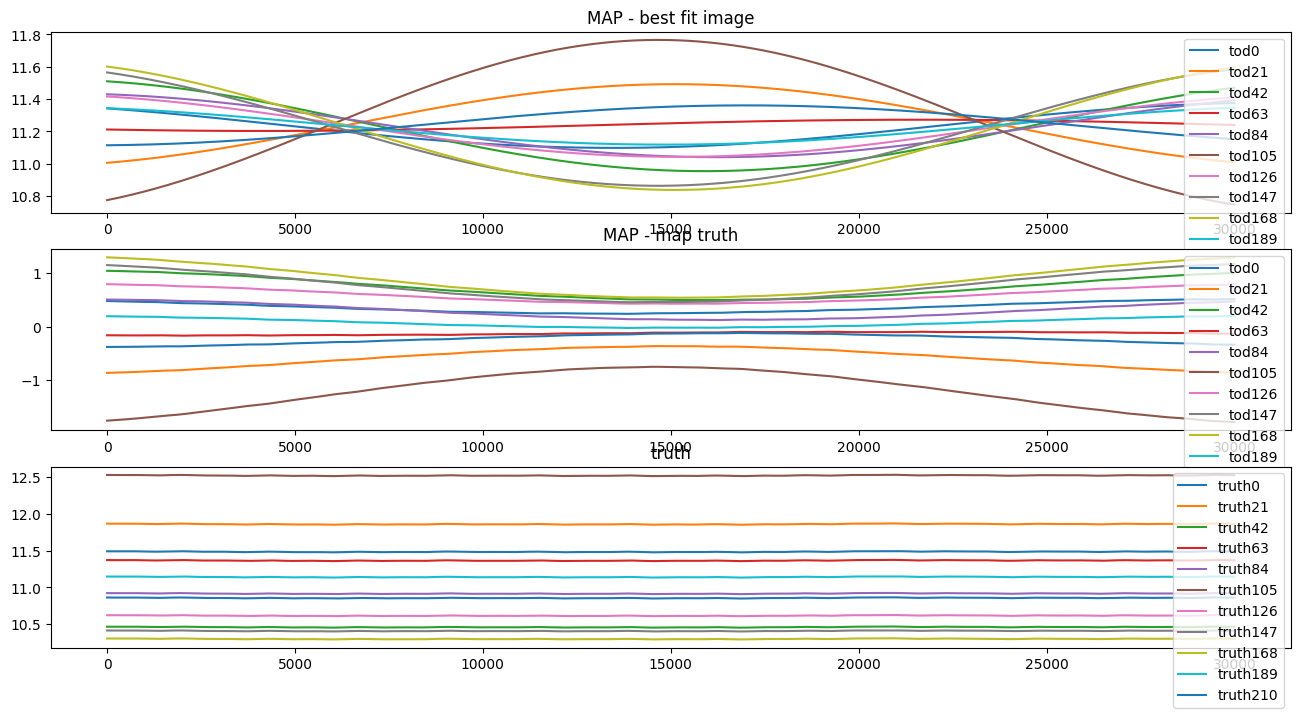

In [28]:
res = signal_response_tod(samples.pos)
print(res.shape)

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

# for i in range(0, res.shape[0], res.shape[0]//10):
for i in range(0, n, n//10):
    im0 = axes[0].plot(np.arange(0, res.shape[1]), res[i], label=f"tod{i}")
    im1 = axes[1].plot(np.arange(0, res.shape[1]), res[i] - truth[i], label=f"tod{i}")
    im2 = axes[2].plot(truth[i], label=f"truth{i}")

axes[0].title.set_text('MAP - best fit image')
axes[0].legend()
axes[1].title.set_text('MAP - map truth')
axes[1].legend()
axes[2].title.set_text('truth')
axes[2].legend()

plt.show()

In [29]:
# # plot maximum of posterior (mode)
# sig_map = gp_map(samples.pos) # when splitting up in different field models

# fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# im0 = axes[0].imshow(sig_map)
# axes[0].title.set_text('MAP - best fit image')
# fig.colorbar(im0)

# im1 = axes[1].imshow( sig_map - mapdata_truth[0] )
# axes[1].title.set_text('MAP - map truth')
# # im1 = axes[1].imshow( (sig_map - mapdata_truth) )
# # axes[1].title.set_text('diff prediction - map truth')
# fig.colorbar(im1)

# plt.show()

In [30]:
# assert False

## Full nifty fit:

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+5.7556e+17 Δ⛰:inf ➽:7.5950e+01
SL: Iteration 1 ⛰:+5.4228e+17 Δ⛰:3.3282e+16 ➽:7.5950e+01
SL: Iteration 2 ⛰:+3.6906e+17 Δ⛰:1.7322e+17 ➽:7.5950e+01
SL: Iteration 3 ⛰:+1.1372e+17 Δ⛰:2.5535e+17 ➽:7.5950e+01
SL: Iteration 4 ⛰:+8.9837e+16 Δ⛰:2.3878e+16 ➽:7.5950e+01
SL: Iteration 5 ⛰:+6.1182e+16 Δ⛰:2.8655e+16 ➽:7.5950e+01
SL: Iteration 6 ⛰:+3.7761e+16 Δ⛰:2.3421e+16 ➽:7.5950e+01
SL: Iteration 7 ⛰:+2.1683e+16 Δ⛰:1.6078e+16 ➽:7.5950e+01
SL: Iteration 8 ⛰:+2.1665e+16 Δ⛰:1.7873e+13 ➽:7.5950e+01
SL: Iteration 9 ⛰:+1.9752e+16 Δ⛰:1.9132e+15 ➽:7.5950e+01
SL: Iteration 10 ⛰:+1.5625e+16 Δ⛰:4.1264e+15 ➽:7.5950e+01
SL: Iteration 11 ⛰:+1.4151e+16 Δ⛰:1.4741e+15 ➽:7.5950e+01
SL: Iteration 12 ⛰:+1.0551e+16 Δ⛰:3.6001e+15 ➽:7.5950e+01
SL: Iteration 13 ⛰:+1.0510e+16 Δ⛰:4.0998e+13 ➽:7.5950e+01
SL: Iteration 14 ⛰:+9.9540e+15 Δ⛰:5.5614e+14 ➽:7.5950e+01
SL: Iteration 15 ⛰:+9.9455e+15 Δ⛰:8.4631e+12 ➽:7.5950e+01
SL: Iteration 16 ⛰:+8.5083e+15 Δ⛰:1.4372e+15 ➽:7.5950e+01
SL: 

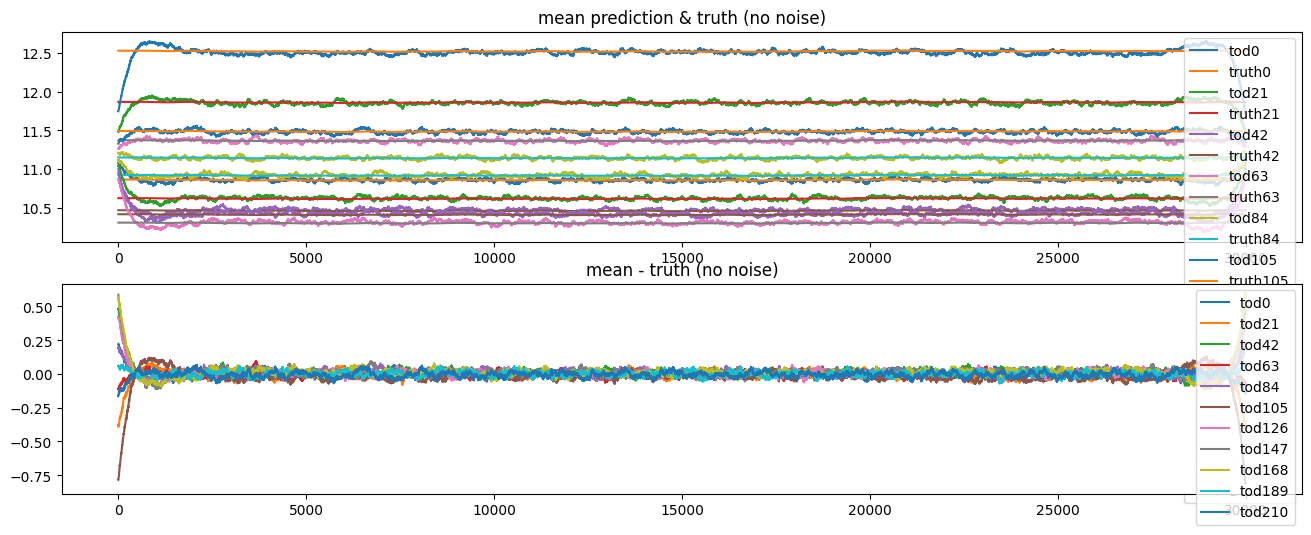

OPTIMIZE_KL: Starting 0002
SL: Iteration 0 ⛰:+3.2297e+21 Δ⛰:inf ➽:7.5950e+01
SL: Iteration 1 ⛰:+2.5879e+20 Δ⛰:2.9709e+21 ➽:7.5950e+01
SL: Iteration 2 ⛰:+2.3938e+20 Δ⛰:1.9409e+19 ➽:7.5950e+01
SL: Iteration 3 ⛰:+2.2762e+20 Δ⛰:1.1762e+19 ➽:7.5950e+01
SL: Iteration 4 ⛰:+8.9910e+19 Δ⛰:1.3770e+20 ➽:7.5950e+01
SL: Iteration 5 ⛰:+5.5198e+19 Δ⛰:3.4712e+19 ➽:7.5950e+01
SL: Iteration 6 ⛰:+5.5196e+19 Δ⛰:1.9881e+15 ➽:7.5950e+01
SL: Iteration 7 ⛰:+3.9970e+19 Δ⛰:1.5226e+19 ➽:7.5950e+01
SL: Iteration 8 ⛰:+2.6428e+19 Δ⛰:1.3542e+19 ➽:7.5950e+01
SL: Iteration 9 ⛰:+2.6416e+19 Δ⛰:1.2009e+16 ➽:7.5950e+01
SL: Iteration 10 ⛰:+2.1346e+19 Δ⛰:5.0702e+18 ➽:7.5950e+01
SL: Iteration 11 ⛰:+2.1341e+19 Δ⛰:5.2960e+15 ➽:7.5950e+01
SL: Iteration 12 ⛰:+1.8204e+19 Δ⛰:3.1365e+18 ➽:7.5950e+01
SL: Iteration 13 ⛰:+1.6975e+19 Δ⛰:1.2297e+18 ➽:7.5950e+01
SL: Iteration 14 ⛰:+1.6933e+19 Δ⛰:4.1466e+16 ➽:7.5950e+01
SL: Iteration 15 ⛰:+1.6674e+19 Δ⛰:2.5957e+17 ➽:7.5950e+01
SL: Iteration 16 ⛰:+1.5318e+19 Δ⛰:1.3560e+18 ➽:7.5950e+01
SL: 

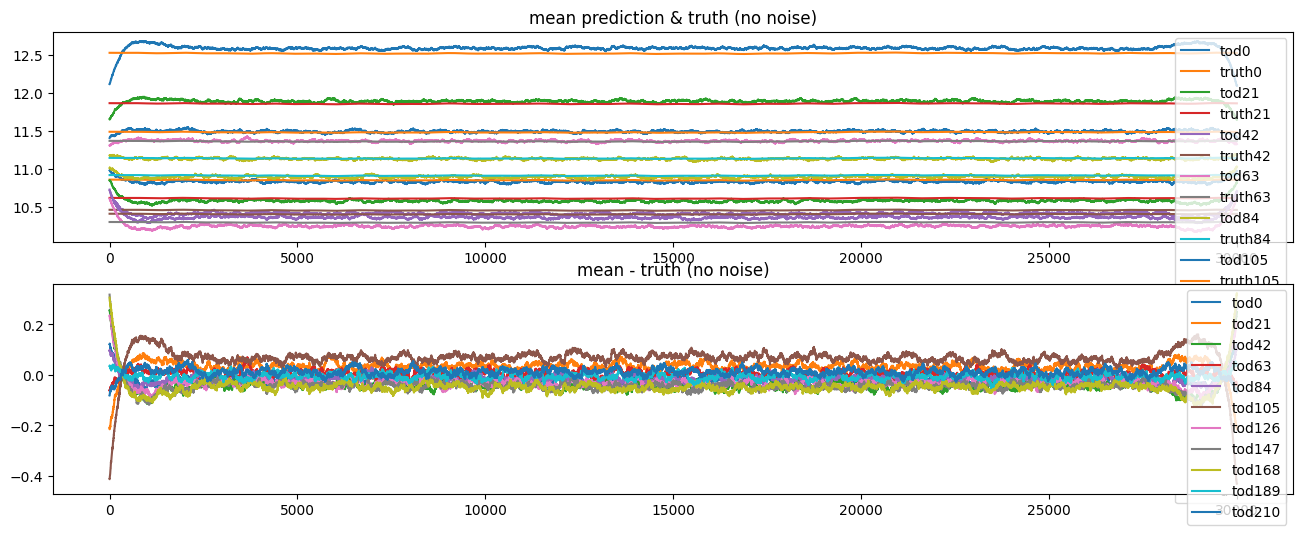

OPTIMIZE_KL: Starting 0003
SL: Iteration 0 ⛰:+9.5047e+21 Δ⛰:inf ➽:7.5950e+01
SL: Iteration 1 ⛰:+1.1500e+20 Δ⛰:9.3897e+21 ➽:7.5950e+01
SL: Iteration 2 ⛰:+1.1117e+20 Δ⛰:3.8282e+18 ➽:7.5950e+01
SL: Iteration 3 ⛰:+1.0272e+20 Δ⛰:8.4588e+18 ➽:7.5950e+01
SL: Iteration 4 ⛰:+3.7779e+19 Δ⛰:6.4937e+19 ➽:7.5950e+01
SL: Iteration 5 ⛰:+3.7017e+19 Δ⛰:7.6161e+17 ➽:7.5950e+01
SL: Iteration 6 ⛰:+2.1483e+19 Δ⛰:1.5535e+19 ➽:7.5950e+01
SL: Iteration 7 ⛰:+1.6590e+19 Δ⛰:4.8927e+18 ➽:7.5950e+01
SL: Iteration 8 ⛰:+1.1437e+19 Δ⛰:5.1532e+18 ➽:7.5950e+01
SL: Iteration 9 ⛰:+1.1437e+19 Δ⛰:2.3364e+14 ➽:7.5950e+01
SL: Iteration 10 ⛰:+1.1435e+19 Δ⛰:2.0157e+15 ➽:7.5950e+01
SL: Iteration 11 ⛰:+8.8652e+18 Δ⛰:2.5694e+18 ➽:7.5950e+01
SL: Iteration 12 ⛰:+7.7176e+18 Δ⛰:1.1475e+18 ➽:7.5950e+01
SL: Iteration 13 ⛰:+6.8327e+18 Δ⛰:8.8496e+17 ➽:7.5950e+01
SL: Iteration 14 ⛰:+6.8323e+18 Δ⛰:3.8140e+14 ➽:7.5950e+01
SL: Iteration 15 ⛰:+6.8201e+18 Δ⛰:1.2153e+16 ➽:7.5950e+01
SL: Iteration 16 ⛰:+5.9945e+18 Δ⛰:8.2566e+17 ➽:7.5950e+01
SL: 

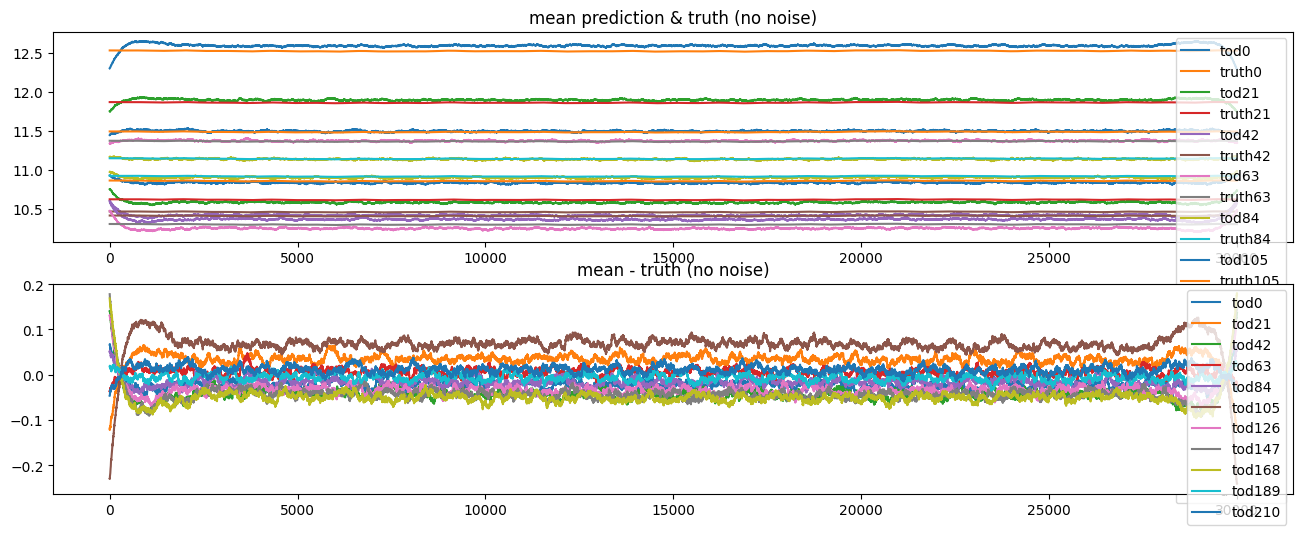

OPTIMIZE_KL: Starting 0004
SL: Iteration 0 ⛰:+4.3422e+21 Δ⛰:inf ➽:7.5950e+01
SL: Iteration 1 ⛰:+8.8087e+19 Δ⛰:4.2541e+21 ➽:7.5950e+01
SL: Iteration 2 ⛰:+4.6594e+19 Δ⛰:4.1493e+19 ➽:7.5950e+01
SL: Iteration 3 ⛰:+4.3768e+19 Δ⛰:2.8264e+18 ➽:7.5950e+01
SL: Iteration 4 ⛰:+1.3292e+19 Δ⛰:3.0476e+19 ➽:7.5950e+01
SL: Iteration 5 ⛰:+1.3292e+19 Δ⛰:3.0635e+13 ➽:7.5950e+01
SL: Iteration 6 ⛰:+8.7458e+18 Δ⛰:4.5462e+18 ➽:7.5950e+01
SL: Iteration 7 ⛰:+5.9859e+18 Δ⛰:2.7599e+18 ➽:7.5950e+01
SL: Iteration 8 ⛰:+5.1729e+18 Δ⛰:8.1300e+17 ➽:7.5950e+01
SL: Iteration 9 ⛰:+5.1632e+18 Δ⛰:9.7321e+15 ➽:7.5950e+01
SL: Iteration 10 ⛰:+5.1588e+18 Δ⛰:4.3437e+15 ➽:7.5950e+01
SL: Iteration 11 ⛰:+3.7255e+18 Δ⛰:1.4334e+18 ➽:7.5950e+01
SL: Iteration 12 ⛰:+3.0266e+18 Δ⛰:6.9888e+17 ➽:7.5950e+01
SL: Iteration 13 ⛰:+3.0265e+18 Δ⛰:1.0570e+14 ➽:7.5950e+01
SL: Iteration 14 ⛰:+2.7073e+18 Δ⛰:3.1920e+17 ➽:7.5950e+01
SL: Iteration 15 ⛰:+2.6880e+18 Δ⛰:1.9318e+16 ➽:7.5950e+01
SL: Iteration 16 ⛰:+2.4767e+18 Δ⛰:2.1122e+17 ➽:7.5950e+01
SL: 

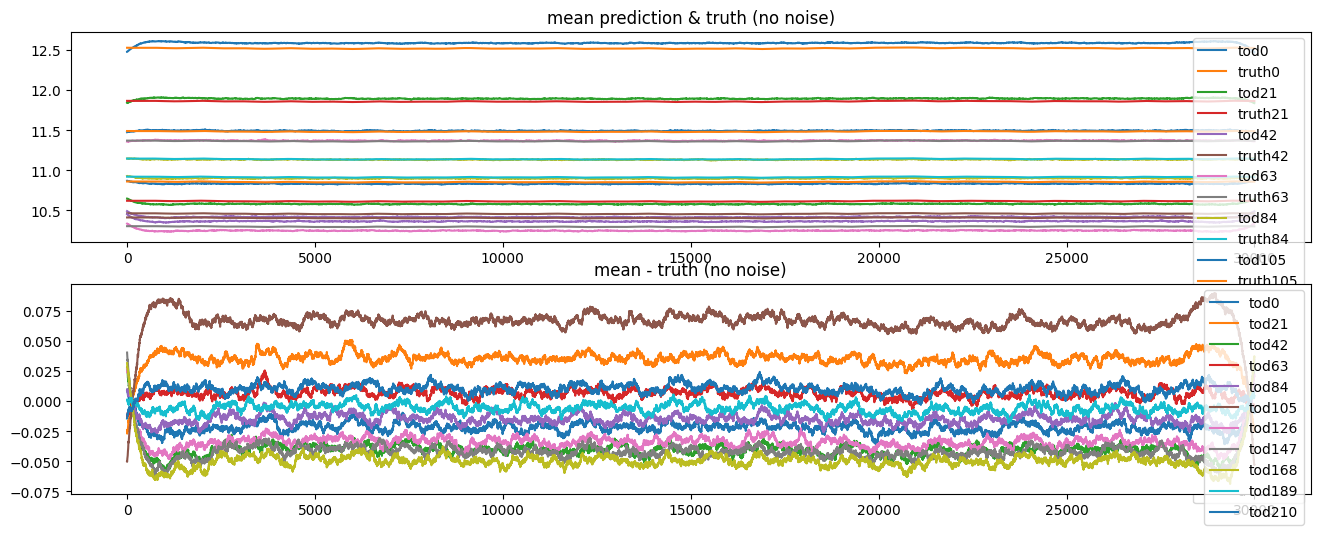

OPTIMIZE_KL: Starting 0005
SL: Iteration 0 ⛰:+6.1892e+20 Δ⛰:inf ➽:7.5950e+01
SL: Iteration 1 ⛰:+2.0504e+19 Δ⛰:5.9841e+20 ➽:7.5950e+01
SL: Iteration 2 ⛰:+1.9446e+19 Δ⛰:1.0581e+18 ➽:7.5950e+01
SL: Iteration 3 ⛰:+9.2599e+18 Δ⛰:1.0186e+19 ➽:7.5950e+01
SL: Iteration 4 ⛰:+4.5532e+18 Δ⛰:4.7066e+18 ➽:7.5950e+01
SL: Iteration 5 ⛰:+4.5492e+18 Δ⛰:4.0751e+15 ➽:7.5950e+01
SL: Iteration 6 ⛰:+1.8208e+18 Δ⛰:2.7284e+18 ➽:7.5950e+01
SL: Iteration 7 ⛰:+1.7062e+18 Δ⛰:1.1459e+17 ➽:7.5950e+01
SL: Iteration 8 ⛰:+1.7057e+18 Δ⛰:4.7540e+14 ➽:7.5950e+01
SL: Iteration 9 ⛰:+1.1149e+18 Δ⛰:5.9077e+17 ➽:7.5950e+01
SL: Iteration 10 ⛰:+8.2556e+17 Δ⛰:2.8937e+17 ➽:7.5950e+01
SL: Iteration 11 ⛰:+8.2481e+17 Δ⛰:7.4698e+14 ➽:7.5950e+01
SL: Iteration 12 ⛰:+8.2481e+17 Δ⛰:1.0406e+11 ➽:7.5950e+01
SL: Iteration 13 ⛰:+5.9398e+17 Δ⛰:2.3083e+17 ➽:7.5950e+01
SL: Iteration 14 ⛰:+5.6637e+17 Δ⛰:2.7610e+16 ➽:7.5950e+01
SL: Iteration 15 ⛰:+5.5050e+17 Δ⛰:1.5873e+16 ➽:7.5950e+01
SL: Iteration 16 ⛰:+5.0656e+17 Δ⛰:4.3939e+16 ➽:7.5950e+01
SL: 

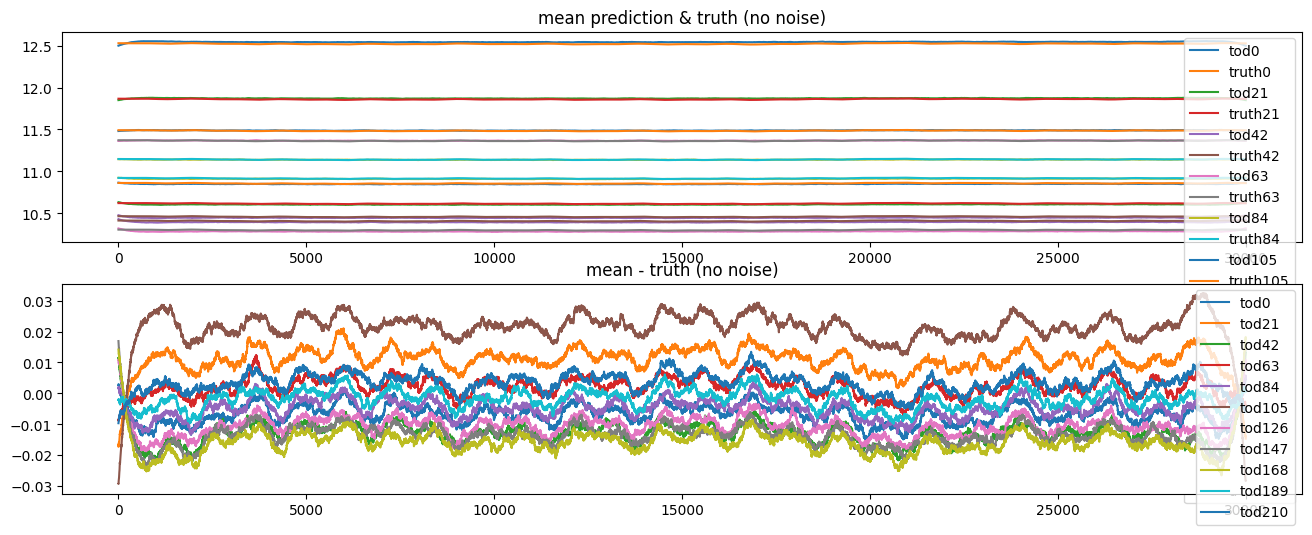

OPTIMIZE_KL: Starting 0006
SL: Iteration 0 ⛰:+2.6465e+22 Δ⛰:inf ➽:7.5950e+01
SL: Iteration 1 ⛰:+1.3643e+19 Δ⛰:2.6452e+22 ➽:7.5950e+01
SL: Iteration 2 ⛰:+1.0515e+19 Δ⛰:3.1275e+18 ➽:7.5950e+01
SL: Iteration 3 ⛰:+9.1325e+17 Δ⛰:9.6018e+18 ➽:7.5950e+01
SL: Iteration 4 ⛰:+9.1322e+17 Δ⛰:2.2123e+13 ➽:7.5950e+01
SL: Iteration 5 ⛰:+8.8336e+17 Δ⛰:2.9866e+16 ➽:7.5950e+01
SL: Iteration 6 ⛰:+3.2060e+17 Δ⛰:5.6275e+17 ➽:7.5950e+01
SL: Iteration 7 ⛰:+3.0690e+17 Δ⛰:1.3707e+16 ➽:7.5950e+01
SL: Iteration 8 ⛰:+3.0688e+17 Δ⛰:2.2090e+13 ➽:7.5950e+01
SL: Iteration 9 ⛰:+2.0232e+17 Δ⛰:1.0455e+17 ➽:7.5950e+01
SL: Iteration 10 ⛰:+1.9973e+17 Δ⛰:2.5940e+15 ➽:7.5950e+01
SL: Iteration 11 ⛰:+1.9973e+17 Δ⛰:1.0183e+11 ➽:7.5950e+01
SL: Iteration 12 ⛰:+1.4247e+17 Δ⛰:5.7263e+16 ➽:7.5950e+01
SL: Iteration 13 ⛰:+1.4237e+17 Δ⛰:9.7278e+13 ➽:7.5950e+01
SL: Iteration 14 ⛰:+1.0149e+17 Δ⛰:4.0877e+16 ➽:7.5950e+01
SL: Iteration 15 ⛰:+9.6947e+16 Δ⛰:4.5458e+15 ➽:7.5950e+01
SL: Iteration 16 ⛰:+8.4754e+16 Δ⛰:1.2193e+16 ➽:7.5950e+01
SL: 

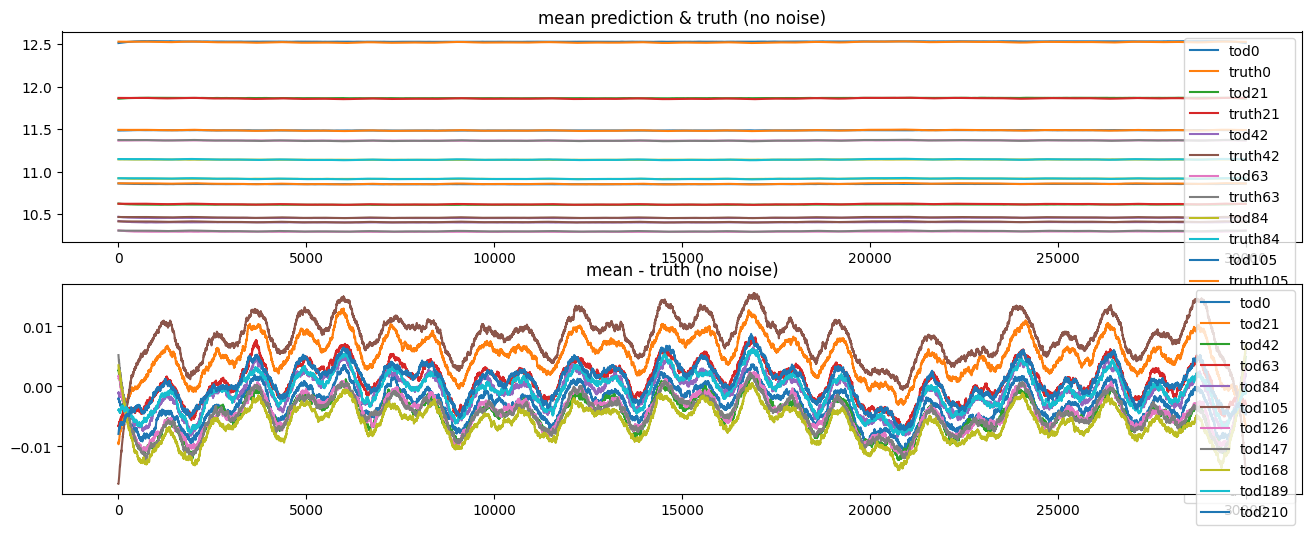

OPTIMIZE_KL: Starting 0007
SL: Iteration 0 ⛰:+6.1548e+21 Δ⛰:inf ➽:7.5950e+01
SL: Iteration 1 ⛰:+1.3709e+19 Δ⛰:6.1411e+21 ➽:7.5950e+01
SL: Iteration 2 ⛰:+4.7720e+17 Δ⛰:1.3232e+19 ➽:7.5950e+01
SL: Iteration 3 ⛰:+1.5396e+17 Δ⛰:3.2324e+17 ➽:7.5950e+01
SL: Iteration 4 ⛰:+1.5396e+17 Δ⛰:2.5349e+11 ➽:7.5950e+01
SL: Iteration 5 ⛰:+1.4923e+17 Δ⛰:4.7319e+15 ➽:7.5950e+01
SL: Iteration 6 ⛰:+1.3379e+17 Δ⛰:1.5434e+16 ➽:7.5950e+01
SL: Iteration 7 ⛰:+1.2289e+17 Δ⛰:1.0904e+16 ➽:7.5950e+01
SL: Iteration 8 ⛰:+5.2781e+16 Δ⛰:7.0107e+16 ➽:7.5950e+01
SL: Iteration 9 ⛰:+4.6342e+16 Δ⛰:6.4392e+15 ➽:7.5950e+01
SL: Iteration 10 ⛰:+3.4744e+16 Δ⛰:1.1598e+16 ➽:7.5950e+01
SL: Iteration 11 ⛰:+3.4633e+16 Δ⛰:1.1031e+14 ➽:7.5950e+01
SL: Iteration 12 ⛰:+2.4566e+16 Δ⛰:1.0067e+16 ➽:7.5950e+01
SL: Iteration 13 ⛰:+2.4157e+16 Δ⛰:4.0889e+14 ➽:7.5950e+01
SL: Iteration 14 ⛰:+1.6919e+16 Δ⛰:7.2385e+15 ➽:7.5950e+01
SL: Iteration 15 ⛰:+1.6855e+16 Δ⛰:6.4133e+13 ➽:7.5950e+01
SL: Iteration 16 ⛰:+1.5196e+16 Δ⛰:1.6588e+15 ➽:7.5950e+01
SL: 

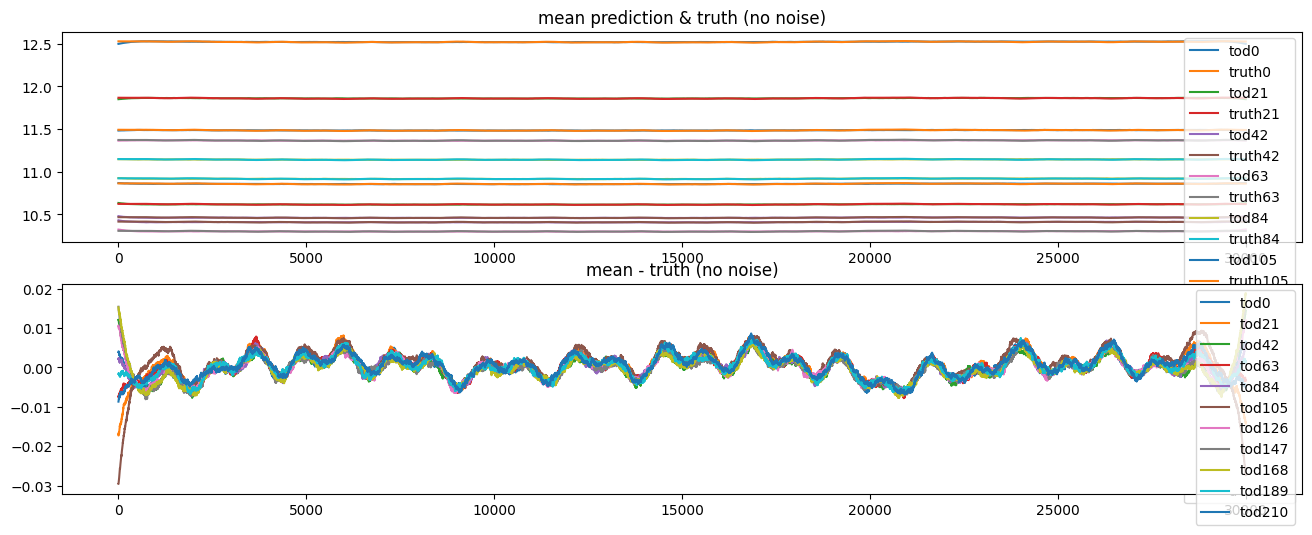

OPTIMIZE_KL: Starting 0008
SL: Iteration 0 ⛰:+1.0950e+23 Δ⛰:inf ➽:7.5950e+01
SL: Iteration 1 ⛰:+1.3381e+19 Δ⛰:1.0949e+23 ➽:7.5950e+01
SL: Iteration 2 ⛰:+5.3807e+17 Δ⛰:1.2843e+19 ➽:7.5950e+01
SL: Iteration 3 ⛰:+2.6400e+17 Δ⛰:2.7407e+17 ➽:7.5950e+01
SL: Iteration 4 ⛰:+2.6400e+17 Δ⛰:4.1718e+10 ➽:7.5950e+01
SL: Iteration 5 ⛰:+2.5920e+17 Δ⛰:4.7959e+15 ➽:7.5950e+01
SL: Iteration 6 ⛰:+1.7329e+17 Δ⛰:8.5910e+16 ➽:7.5950e+01
SL: Iteration 7 ⛰:+9.7717e+16 Δ⛰:7.5576e+16 ➽:7.5950e+01
SL: Iteration 8 ⛰:+9.6684e+16 Δ⛰:1.0324e+15 ➽:7.5950e+01
SL: Iteration 9 ⛰:+6.9760e+16 Δ⛰:2.6924e+16 ➽:7.5950e+01
SL: Iteration 10 ⛰:+6.3186e+16 Δ⛰:6.5740e+15 ➽:7.5950e+01
SL: Iteration 11 ⛰:+6.3186e+16 Δ⛰:1.2608e+10 ➽:7.5950e+01
SL: Iteration 12 ⛰:+4.4870e+16 Δ⛰:1.8316e+16 ➽:7.5950e+01
SL: Iteration 13 ⛰:+3.0473e+16 Δ⛰:1.4397e+16 ➽:7.5950e+01
SL: Iteration 14 ⛰:+3.0473e+16 Δ⛰:1.7605e+11 ➽:7.5950e+01
SL: Iteration 15 ⛰:+3.0460e+16 Δ⛰:1.3553e+13 ➽:7.5950e+01
SL: Iteration 16 ⛰:+2.5149e+16 Δ⛰:5.3102e+15 ➽:7.5950e+01
SL: 

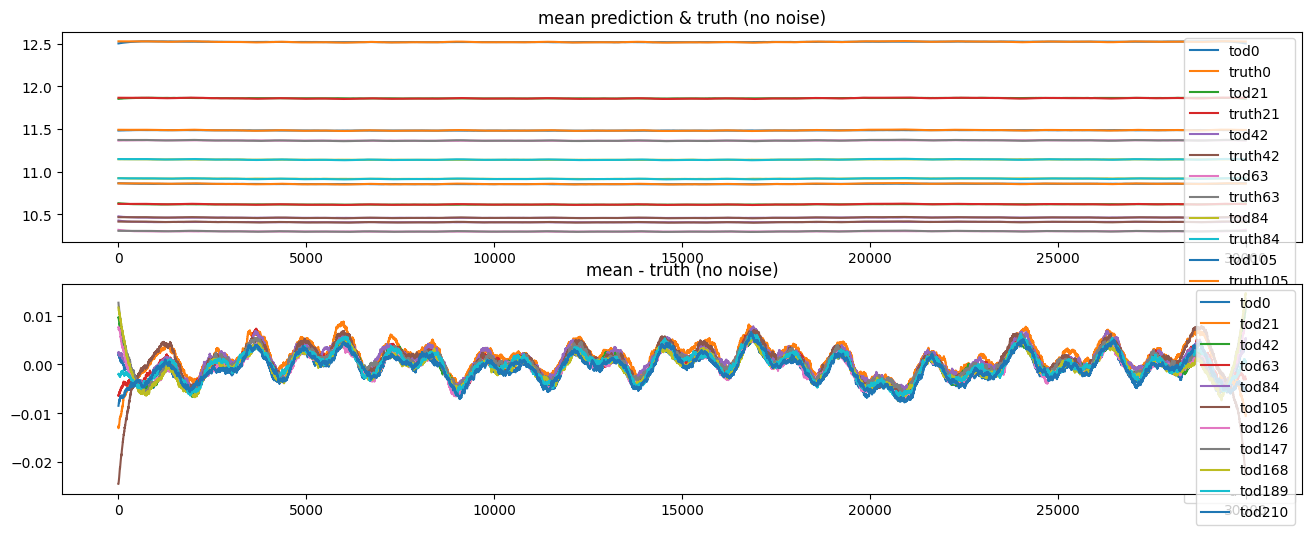

OPTIMIZE_KL: Starting 0009
SL: Iteration 0 ⛰:+6.0141e+21 Δ⛰:inf ➽:7.5950e+01
SL: Iteration 1 ⛰:+1.2301e+19 Δ⛰:6.0018e+21 ➽:7.5950e+01
SL: Iteration 2 ⛰:+4.4997e+17 Δ⛰:1.1852e+19 ➽:7.5950e+01
SL: Iteration 3 ⛰:+1.8882e+17 Δ⛰:2.6116e+17 ➽:7.5950e+01
SL: Iteration 4 ⛰:+1.8882e+17 Δ⛰:8.5265e+10 ➽:7.5950e+01
SL: Iteration 5 ⛰:+1.8442e+17 Δ⛰:4.3935e+15 ➽:7.5950e+01
SL: Iteration 6 ⛰:+1.7917e+17 Δ⛰:5.2591e+15 ➽:7.5950e+01
SL: Iteration 7 ⛰:+6.5761e+16 Δ⛰:1.1340e+17 ➽:7.5950e+01
SL: Iteration 8 ⛰:+6.5692e+16 Δ⛰:6.8714e+13 ➽:7.5950e+01
SL: Iteration 9 ⛰:+4.9282e+16 Δ⛰:1.6411e+16 ➽:7.5950e+01
SL: Iteration 10 ⛰:+4.2089e+16 Δ⛰:7.1922e+15 ➽:7.5950e+01
SL: Iteration 11 ⛰:+4.2089e+16 Δ⛰:3.6207e+08 ➽:7.5950e+01
SL: Iteration 12 ⛰:+2.9387e+16 Δ⛰:1.2703e+16 ➽:7.5950e+01
SL: Iteration 13 ⛰:+2.0169e+16 Δ⛰:9.2178e+15 ➽:7.5950e+01
SL: Iteration 14 ⛰:+2.0169e+16 Δ⛰:7.5723e+09 ➽:7.5950e+01
SL: Iteration 15 ⛰:+2.0160e+16 Δ⛰:8.9930e+12 ➽:7.5950e+01
SL: Iteration 16 ⛰:+1.8174e+16 Δ⛰:1.9861e+15 ➽:7.5950e+01
SL: 

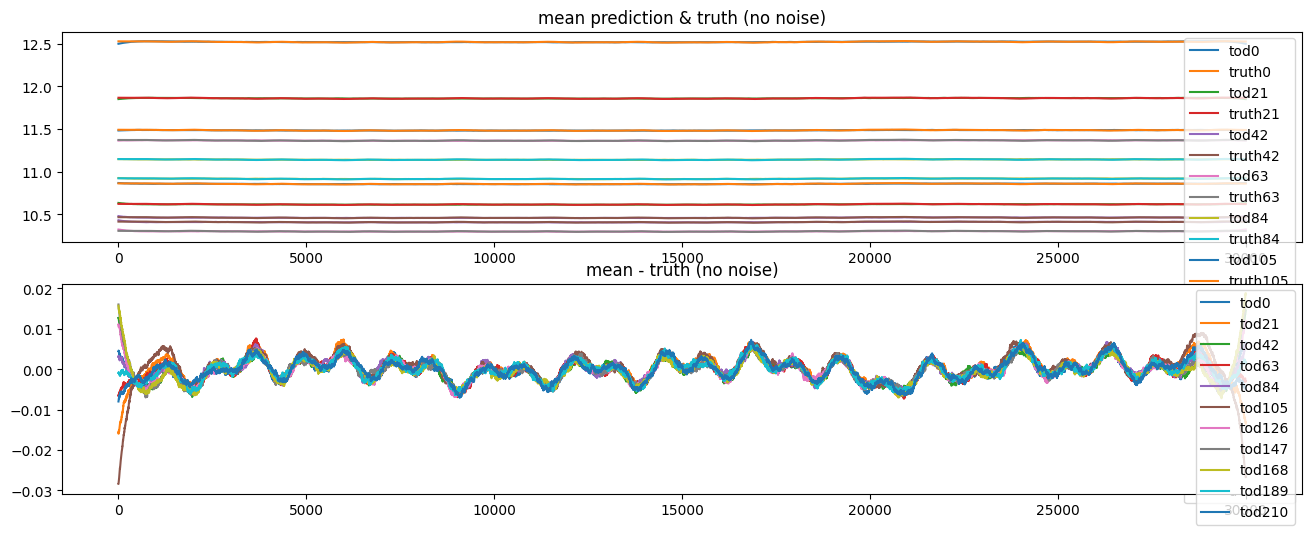

OPTIMIZE_KL: Starting 0010
SL: Iteration 0 ⛰:+1.4630e+22 Δ⛰:inf ➽:7.5950e+01
SL: Iteration 1 ⛰:+1.1176e+19 Δ⛰:1.4618e+22 ➽:7.5950e+01
SL: Iteration 2 ⛰:+1.1898e+18 Δ⛰:9.9859e+18 ➽:7.5950e+01
SL: Iteration 3 ⛰:+2.8066e+17 Δ⛰:9.0913e+17 ➽:7.5950e+01
SL: Iteration 4 ⛰:+2.8066e+17 Δ⛰:1.8580e+11 ➽:7.5950e+01
SL: Iteration 5 ⛰:+2.7397e+17 Δ⛰:6.6985e+15 ➽:7.5950e+01
SL: Iteration 6 ⛰:+9.4474e+16 Δ⛰:1.7949e+17 ➽:7.5950e+01
SL: Iteration 7 ⛰:+9.4352e+16 Δ⛰:1.2177e+14 ➽:7.5950e+01
SL: Iteration 8 ⛰:+9.3703e+16 Δ⛰:6.4854e+14 ➽:7.5950e+01
SL: Iteration 9 ⛰:+6.5689e+16 Δ⛰:2.8015e+16 ➽:7.5950e+01
SL: Iteration 10 ⛰:+6.2383e+16 Δ⛰:3.3058e+15 ➽:7.5950e+01
SL: Iteration 11 ⛰:+6.2383e+16 Δ⛰:7.3449e+08 ➽:7.5950e+01
SL: Iteration 12 ⛰:+4.4180e+16 Δ⛰:1.8202e+16 ➽:7.5950e+01
SL: Iteration 13 ⛰:+3.1704e+16 Δ⛰:1.2476e+16 ➽:7.5950e+01
SL: Iteration 14 ⛰:+3.1704e+16 Δ⛰:2.0284e+11 ➽:7.5950e+01
SL: Iteration 15 ⛰:+3.0619e+16 Δ⛰:1.0851e+15 ➽:7.5950e+01
SL: Iteration 16 ⛰:+2.7634e+16 Δ⛰:2.9851e+15 ➽:7.5950e+01
SL: 

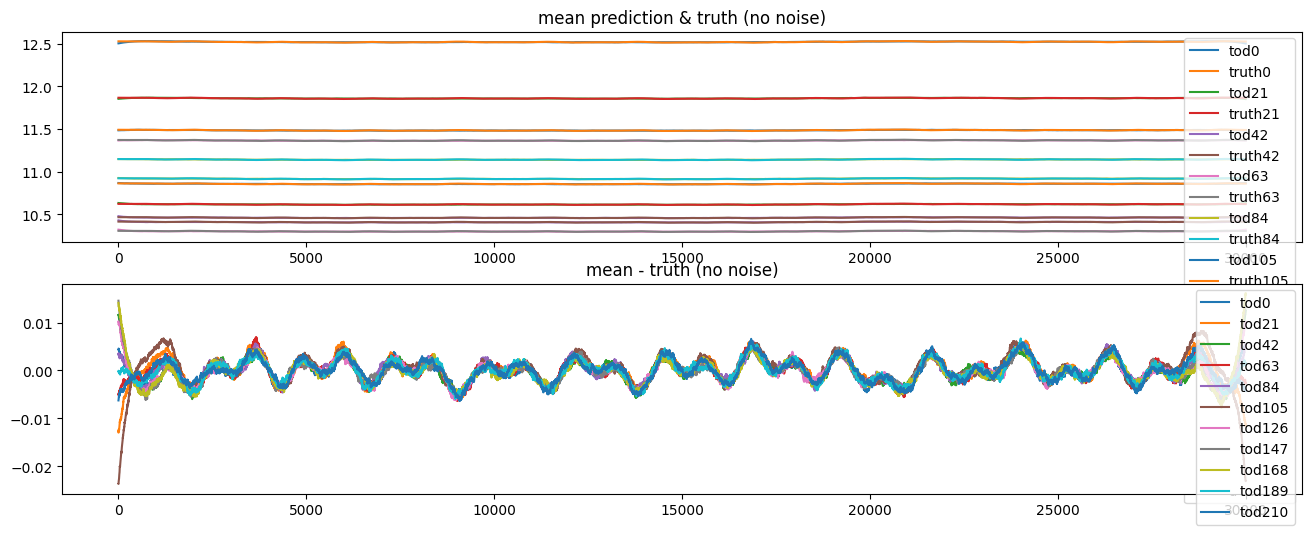

In [31]:
n_it = 10
# n_it = 30
# n_it = 50

if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4
n_samples = 4 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

# callback fn for plotting during optimisation:
def callback(samples, opt_state):
    mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

    fig_tods, axes_tods = plt.subplots(2, 1, figsize=(16, 6))

    # for i in range(0, mean.shape[0], mean.shape[0]//10):
    # for i in range(n):
    for i in range(0, n, n//10):
        axes_tods[0].plot(np.arange(0, mean.shape[1]), mean[i], label=f"tod{i}")
        axes_tods[0].plot(denoised_jax_tod[i], label=f"truth{i}")
        axes_tods[1].plot(np.arange(0, mean.shape[1]), mean[i] - denoised_jax_tod[i], label=f"tod{i}")

    axes_tods[0].title.set_text('mean prediction & truth (no noise)')
    axes_tods[0].legend()
    axes_tods[1].title.set_text('mean - truth (no noise)')
    axes_tods[1].legend()

    # fig_map, axes_map = plt.subplots(1, 3, figsize=(16, 6))

    # mean_map, _ = jft.mean_and_std(tuple(gp_map(s) for s in samples))

    # im0 = axes_map[0].imshow(mean_map)
    # axes_map[0].title.set_text('mean map pred.')
    # fig_map.colorbar(im0)

    # im1 = axes_map[1].imshow(mean_map - mapdata_truth[0])
    # axes_map[1].title.set_text('mean map - truth')
    # fig_map.colorbar(im1)

    # im2 = axes_map[2].imshow(mapdata_truth[0])
    # axes_map[2].title.set_text('truth')
    # fig_map.colorbar(im2)

    plt.show()
    

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
        # cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=10),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=10
        )
    ),
    # sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
    sample_mode = lambda x: "nonlinear_resample" if x >= 1 else "linear_resample",
    callback=callback,
)

In [32]:
printfitresults()

Fit Results (res, init, std)

TODs:
	fluctuations: 0.00266642908975111, 0.005, 0.003
	loglogvarslope: -1.8042363959017373, -3, 0.5
	zeromode std (LogNormal): 0.019719009377029324, 0.0005, 0.001


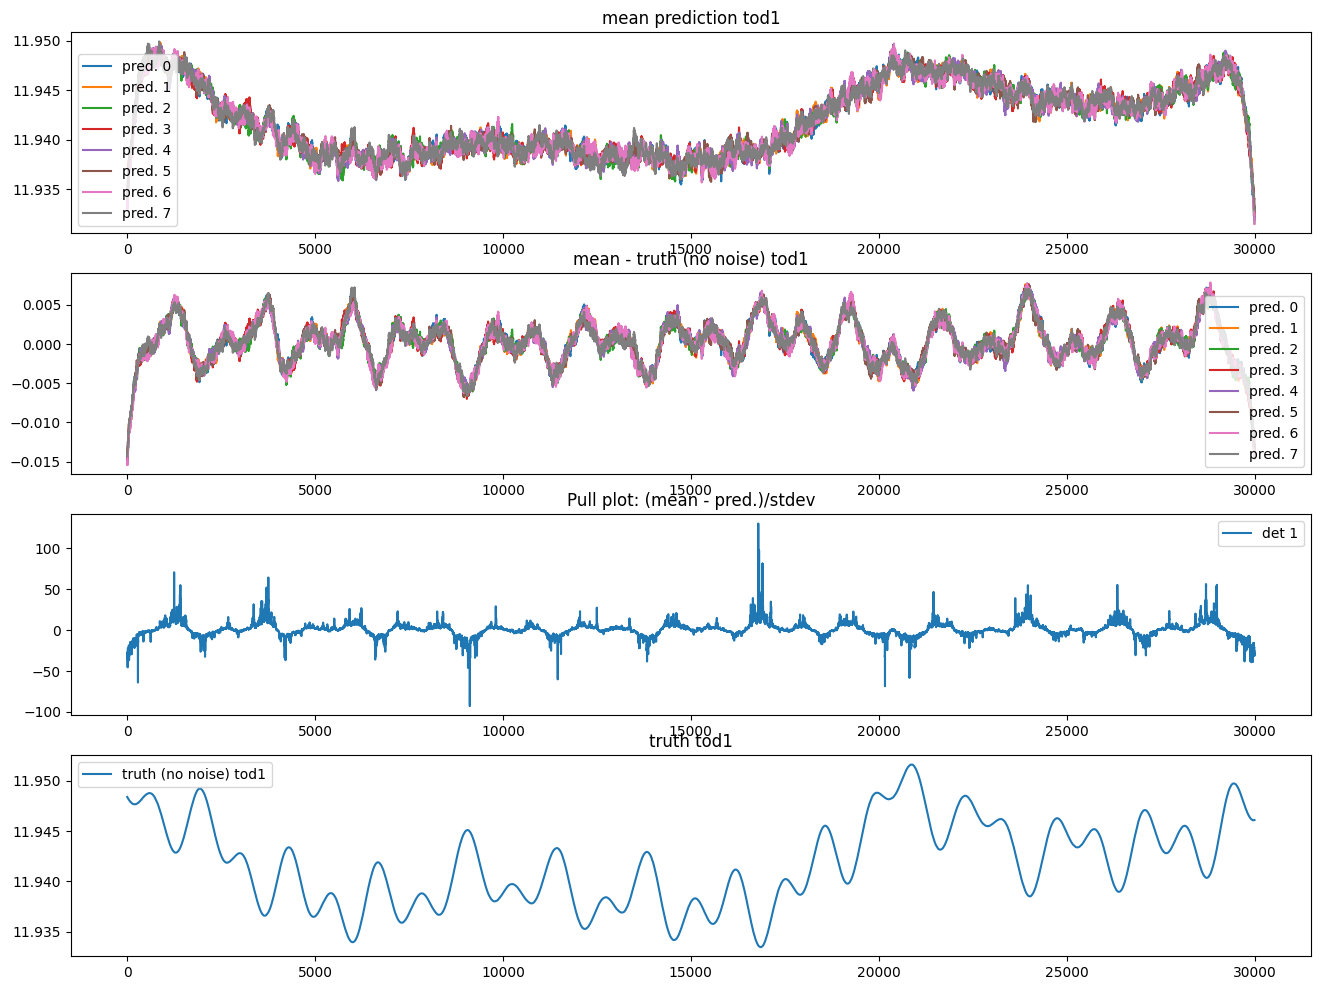

In [33]:
mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
i = 1 # TOD id
j = 0
# for i in range(mean.shape[0]):
for s in samples:
    pred = signal_response_tod(s)
    
    im0 = axes[0].plot(np.arange(0, pred.shape[1]), pred[i], label=f"pred. {j}")
    im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i], label=f"pred. {j}")
    j += 1

im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i])/std[i], label=f"det {i}")
im3 = axes[3].plot(denoised_jax_tod[i], label=f"truth (no noise) tod{i}")
axes[0].title.set_text(f"mean prediction tod{i}")
axes[0].legend()
axes[1].title.set_text(f"mean - truth (no noise) tod{i}")
axes[1].legend()
axes[2].title.set_text(f"Pull plot: (mean - pred.)/stdev")
axes[2].legend()
axes[3].title.set_text(f"truth tod{i}")
axes[3].legend()

plt.show()

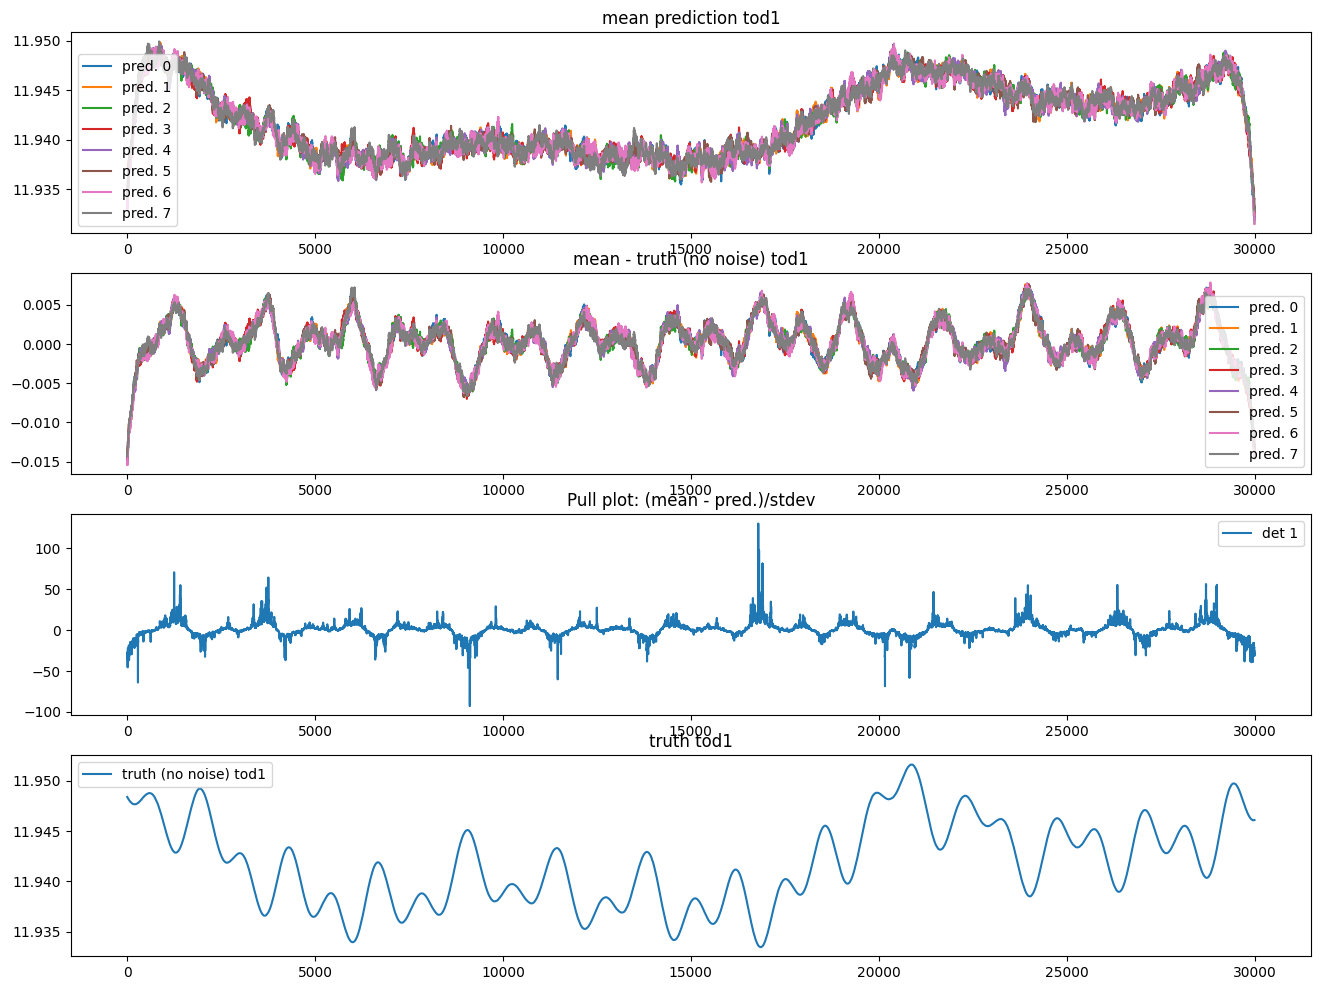

In [34]:
fig, axes = plt.subplots(4, 1, figsize=(16, 12))
i = 1 # TOD id
j = 0
# for i in range(mean.shape[0]):
for s in samples:
    pred = signal_response_tod(s)
    
    im0 = axes[0].plot(np.arange(0, pred.shape[1]), pred[i], label=f"pred. {j}")
    im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i], label=f"pred. {j}")
    j += 1

im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i])/std[i], label=f"det {i}")
im3 = axes[3].plot(denoised_jax_tod[i], label=f"truth (no noise) tod{i}")
axes[0].title.set_text(f"mean prediction tod{i}")
axes[0].legend()
axes[1].title.set_text(f"mean - truth (no noise) tod{i}")
axes[1].legend()
axes[2].title.set_text(f"Pull plot: (mean - pred.)/stdev")
axes[2].legend()
axes[3].title.set_text(f"truth tod{i}")
axes[3].legend()

plt.show()

## Compare with maria mapper:

In [39]:
# from maria.map.mappers import BinMapper

# mapper = BinMapper(center=(150, 10),
#                    frame="ra_dec",
#                    width=0.1,
#                    height=0.1,
#                    resolution=2e-4,
#                    tod_preprocessing={
#                         "window": {"tukey": {"alpha": 0.1}},
#                         "remove_modes": {"n": 1},
#                         "filter": {"f_lower": 0.01},
#                         "despline": {"knot_spacing": 5},
#                                     },
#                     map_postprocessing={
#                         "gaussian_filter": {"sigma": 1},
#                         "median_filter": {"size": 1},
#                                     },
#                    units="K_RJ",
#                    tods=[tod_truthmap],
#                    )

# output_map = mapper.run()

In [40]:
# output_map.plot()

In [38]:
# from skimage.transform import resize

# # Compare nifty vs maria
# sig_map = gp_map(samples.pos) # when splitting up in different field models
# # mincol = -0.0012
# # maxcol = 0.
# mincol = None
# maxcol = None

# cmb_cmap = plt.get_cmap('cmb')
# fig, axes = plt.subplots(3, 2, figsize=(16, 16))

# im0 = axes[0,0].imshow( mapdata_truth[0] , cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
# axes[0,0].title.set_text('truth')
# fig.colorbar(im0)

# im1 = axes[0,1].imshow(output_truthmap.data[0], cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
# fig.colorbar(im1)
# axes[0,1].title.set_text("Noisy image (Mapper output)")

# im2 = axes[1,0].imshow(output_map.data[0], cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
# axes[1,0].title.set_text('maria mapper')
# fig.colorbar(im2)

# truth_rescaled = resize(mapdata_truth[0], (500, 500), anti_aliasing=True)
# im3 = axes[1,1].imshow((output_map.data[0] - truth_rescaled), cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
# axes[1,1].title.set_text('maria - truth')
# fig.colorbar(im3)

# im3 = axes[2,0].imshow(sig_map, cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
# axes[2,0].title.set_text('best fit image')
# fig.colorbar(im3)

# im4 = axes[2,1].imshow((sig_map - mapdata_truth[0]), cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
# axes[2,1].title.set_text('best fit - truth')
# fig.colorbar(im4)

# plt.show()